In [98]:
import pandas as pd
import numpy as np
import matplotlib as mt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from itertools import compress
from scipy import stats
from scipy.stats import loguniform

In [14]:
#loading raw data
PATH_TO_DATA = 'C:\\Users\\user\\Desktop\\4IZ580\\data\\'

df_heart = pd.read_csv(PATH_TO_DATA+'heart.csv',encoding='utf-8')
df_saturation = pd.read_csv(PATH_TO_DATA+'o2Saturation.csv',encoding='utf-8')


In [15]:
#Treating missing values
class attributes:
    def __init__(self,df,column = None):
        self.column = column
        self.df = df
    
    def get_dtypes(self):
        dtype = self.df[f'{self.column}'].dtype
        tmp_dict = {'column':[self.column],'dtype':[dtype]}
        return tmp_dict

    def check_null_values(self):
        null_count = self.df[f'{self.column}'].isnull().sum()
        tmp_dict = {'column':[self.column],'null_count':[null_count]}
        return tmp_dict
    
    def check_duplication(self):
        if self.df.duplicated().sum() > 0:
            print('duplicates detected')
            self.df.drop_duplicates(keep='first',inplace=True)
            self.df.reset_index(drop=True,inplace=True)
        else:
            print('no duplicates were detected')
        
def clean_dataset(df_heart):
    df_info = pd.DataFrame()
    for column in list(df_heart.columns):
        column_dtype = pd.DataFrame.from_dict(attributes(df=df_heart,column=column).get_dtypes())
        column_null_values = pd.DataFrame.from_dict(attributes(df=df_heart,column=column).check_null_values())
        df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
    attributes(df=df_heart).check_duplication()
    return df_info

In [16]:
df_heart["sex"] = df_heart["sex"].astype("category")
df_heart["cp"] = df_heart["cp"].astype("category")
df_heart["fbs"] = df_heart["fbs"].astype("bool")
df_heart["restecg"] = df_heart["restecg"].astype("category")
df_heart["exng"] = df_heart["exng"].astype("bool")
df_heart["slp"] = df_heart["slp"].astype("category")
df_heart["caa"] = df_heart["caa"].astype("category")
df_heart["thall"] = df_heart["thall"].astype("category")

df_heart["output"] = df_heart["output"].astype("bool")


True     0.544554
False    0.455446
Name: output, dtype: float64


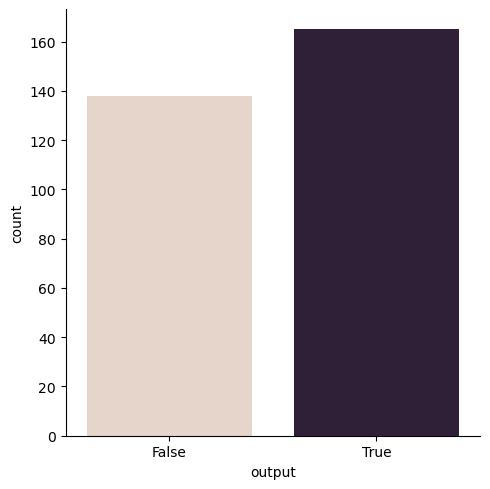

In [17]:
# show histogram of target variable
print(df_heart["output"].value_counts(normalize=True))
sns.catplot(data = df_heart, x = "output", kind = "count", palette = "ch:.11")


Data split

In [18]:
seed = 333

In [19]:
target = df_heart["output"]
feature = df_heart.drop("output", axis= 1)

variable_names = list(feature.columns[:])

X = df_heart[variable_names]
y = target

In [20]:
#dataset division into training, testing and validation dataset
_, X_test, __, y_test = train_test_split(X, y, test_size=0.15, random_state = seed, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(_, __, test_size=0.1764, random_state = seed, stratify=__)

print("X_test", X_test.shape[0])
print("y_test", y_test.shape[0])
print("X_train", X_train.shape[0])
print("y_train", y_train.shape[0])
print("X_valid", X_valid.shape[0])
print("y_valid", y_valid.shape[0])

X_test 46
y_test 46
X_train 211
y_train 211
X_valid 46
y_valid 46


In [40]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=seed)

In [22]:
# Four selected models:
dt = DecisionTreeClassifier(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
lr = LogisticRegression(random_state = seed)


Hyperparameter Space

In [60]:
#Každému z modelů definujeme hyperparametrový prostor, ze kterých budeme v příštích krocích vybírat optimální sady hyperparametrů 

#Hyperparameter space - Logistic regression
lr_space = dict()
lr_space['solver'] = ['newton-cg', 'lbfgs', "sag"]
lr_space['penalty'] = ['l2']
lr_space['C'] = loguniform(1e-5, 10000)
lr_space["max_iter"] = list(range(100,10000,100))

#Hyperparameter space - Decision Tree
dt_space = dict()
dt_space["criterion"] = ["gini", "entropy", "log_loss"]
dt_space["max_depth"] = list(range(4,100,2))
dt_space["max_features"] = list(range(2,30,2)) + ['sqrt', "log2"]
#Hyperparameter space - Random Forest
rf_space = dict()
rf_space["criterion"] = ["gini", "entropy", "log_loss"]
rf_space["max_depth"] = list(range(4,100,2))
rf_space["max_features"] = list(range(2,30,2)) + ['sqrt', "log2"]
rf_space["n_estimators"] = list(range(100,1000,50))





In [61]:
#Random_Forest
r_search_rf = RandomizedSearchCV(estimator = rf, param_distributions= rf_space, cv=cv, random_state=seed, scoring = "f1")
r_search_rf.fit(X_train, y_train)
rs_rf_param = r_search_rf.best_params_

#Decision_Tree
r_search_dt = RandomizedSearchCV(estimator = dt, param_distributions= dt_space, cv=cv, random_state=seed, scoring = "f1")
r_search_dt.fit(X_train, y_train)
rs_dt_param = r_search_dt.best_params_

#Logistic_Regression
r_search_lr = RandomizedSearchCV(estimator = lr, param_distributions= lr_space, cv=cv, random_state=seed, scoring = "f1")
r_search_lr.fit(X_train, y_train)
rs_lr_param = r_search_lr.best_params_



print("Random_Forest:", rs_rf_param)
print("Decision_Tree:", rs_dt_param)
print("Logistic_Regression:", rs_lr_param)


Random_Forest: {'n_estimators': 800, 'max_features': 2, 'max_depth': 74, 'criterion': 'entropy'}
Decision_Tree: {'max_features': 8, 'max_depth': 88, 'criterion': 'entropy'}
Logistic_Regression: {'C': 1.9446186926395421, 'max_iter': 2400, 'penalty': 'l2', 'solver': 'lbfgs'}


In [62]:
#Ulozeni nejlepsich hyperparameter sets
b_rf_est = r_search_rf.best_estimator_
b_dt_est = r_search_dt.best_estimator_
b_lr_est = r_search_lr.best_estimator_

Feature Selection

In [63]:
#Random_Forest
rf_feat_sel = RFECV(estimator=b_rf_est, cv=cv, scoring="f1", n_jobs = -1)
rf_feat_sel.fit(X_train, y_train)

#Decision_Tree
dt_feat_sel = RFECV(estimator=b_dt_est, cv=cv, scoring="f1", n_jobs = -1)
dt_feat_sel.fit(X_train, y_train)

#Logistic_Regression
lr_feat_sel = RFECV(estimator=b_lr_est, cv=cv, scoring="f1", n_jobs = -1)
lr_feat_sel.fit(X_train, y_train)


RFECV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=333),
      estimator=LogisticRegression(C=1.9446186926395421, max_iter=2400,
                                   random_state=333),
      n_jobs=-1, scoring='f1')

In [64]:
#Ulozeni vybranych features do listu
rf_selected = list(compress(X_train.columns.tolist(), rf_feat_sel.support_.tolist()))
dt_selected = list(compress(X_train.columns.tolist(), dt_feat_sel.support_.tolist()))
lr_selected = list(compress(X_train.columns.tolist(), lr_feat_sel.support_.tolist()))

In [65]:
#Druhe kolo ladeni hyperparametru, tentokrat pouze na predem vybranych features
#Random_Forest
r_search_rf_final = RandomizedSearchCV(estimator = rf, param_distributions= rf_space, cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_rf_final.fit(X_train[rf_selected], y_train)
b_rf_est_final = r_search_rf_final.best_estimator_

rf_valid_preds = b_rf_est_final.predict_proba(X_valid[rf_selected])[:,1]
rf_valid_auc = roc_auc_score(y_valid, rf_valid_preds)

#Decision_Tree
r_search_dt_final = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_dt_final.fit(X_train[dt_selected], y_train)
b_dt_est_final = r_search_dt_final.best_estimator_

dt_valid_preds = b_dt_est_final.predict_proba(X_valid[dt_selected])[:,1]
dt_valid_auc = roc_auc_score(y_valid, dt_valid_preds)

#Logistic_Regression
r_search_lr_final = RandomizedSearchCV(estimator = lr, param_distributions= lr_space , cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_lr_final.fit(X_train[lr_selected], y_train)
b_lr_est_final = r_search_lr_final.best_estimator_

lr_valid_preds = b_lr_est_final.predict_proba(X_valid[lr_selected])[:,1]
lr_valid_auc = roc_auc_score(y_valid, lr_valid_preds)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 6 folds for each of 10 candidates, totalling 60 fits


In [67]:
#Porovnáme AUC vytuněných modelů:
print("Random_Forest", rf_valid_auc)
print("Decision_Tree", dt_valid_auc)
print("Logistic_Regression", lr_valid_auc)

Random_Forest 0.9314285714285715
Decision_Tree 0.8285714285714286
Logistic_Regression 0.8895238095238095


In [68]:
#Nejlépe vyšel RandomForest
final_model = b_rf_est_final
final_features = rf_selected

In [96]:
#data preparation for the fitting of the final model
y_train = pd.DataFrame(y_train)
y_valid = pd.DataFrame(y_valid)
y_train_valid = pd.concat([y_train,y_valid],axis=0)
X_train_valid = pd.concat((X_train, X_valid))

,output
144,True
245,False
12,True
77,True
123,True
...,...
76,True
28,True
146,True
178,False


In [97]:
final_model.fit(X_train_valid, y_train_valid)

C:\Users\user\AppData\Local\Temp\ipykernel_1884\2337834398.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_model.fit(X_train_valid, y_train_valid)


RandomForestClassifier(criterion='entropy', max_depth=74, max_features=2,
                       n_estimators=800, random_state=333)

In [99]:
#matice záměny s výchozí mezní hodnotou (pokud je pravděpodobnost menší než 0,5, je klasifikována jako "False").
y_preds2 = pd.Series(final_model.predict(X_test))
confusion_matrix(y_test, y_preds2)

array([[15,  6],
       [ 6, 19]], dtype=int64)